This file loads csv data collected from our IMU, plots the accelerometer and gyroscope data, find peaks, and calculate stroke rate.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


In [13]:

# Load the data
file_path = "../downloaded_files/IMU_1.csv"
data = pd.read_csv(file_path, on_bad_lines='skip') 

# Display the first few rows of the dataset to ensure it loaded correctly
print("Data preview:")
print(data.head())

# Flag to show or hide plots
show_plots = True

# Extract the columns
timestamps = data['Time']
accel_x = data['AccelX']
accel_y = data['AccelY']
accel_z = data['AccelZ']
gyro_x = data['GyroX']
gyro_y = data['GyroY']
gyro_z = data['GyroZ']



Data preview:
      Time  AccelX  AccelY  AccelZ  GyroX  GyroY  GyroZ
0  1265143   -4648    9244  -11676   1049   1639  -1046
1  1265154   -4636    9144  -11936   1054   1271  -1097
2  1265166   -4636    8784  -12172    966    947   -863
3  1265178   -4832    8544  -12212    881    155   -418
4  1265190   -5056    8692  -11972    758   -213   -189


In [14]:
from scipy.signal import savgol_filter

# Apply Savitzky-Golay filter twice for extra smoothing
smoothed_accel_x = savgol_filter(savgol_filter(accel_x, window_length=25, polyorder=2), window_length=25, polyorder=2)
smoothed_accel_y = savgol_filter(savgol_filter(accel_y, window_length=25, polyorder=2), window_length=25, polyorder=2)
smoothed_accel_z = savgol_filter(savgol_filter(accel_z, window_length=25, polyorder=2), window_length=25, polyorder=2)
smoothed_gyro_x = savgol_filter(savgol_filter(gyro_x, window_length=25, polyorder=2), window_length=25, polyorder=2)
smoothed_gyro_y = savgol_filter(savgol_filter(gyro_y, window_length=25, polyorder=2), window_length=25, polyorder=2)
smoothed_gyro_z = savgol_filter(savgol_filter(gyro_z, window_length=25, polyorder=2), window_length=25, polyorder=2)


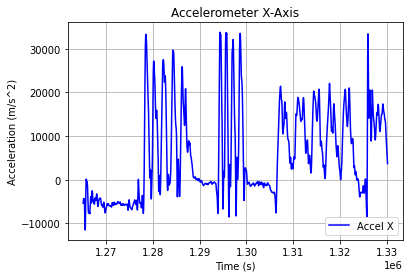

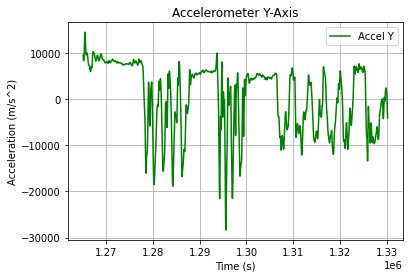

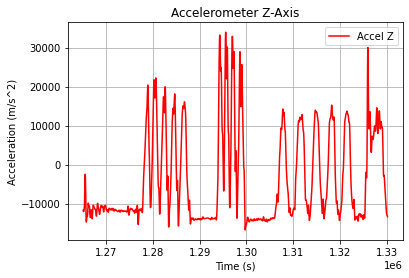

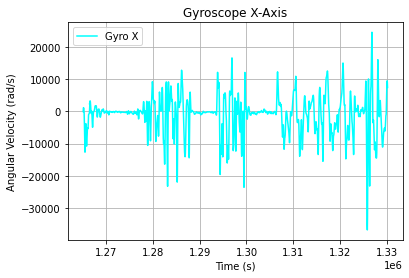

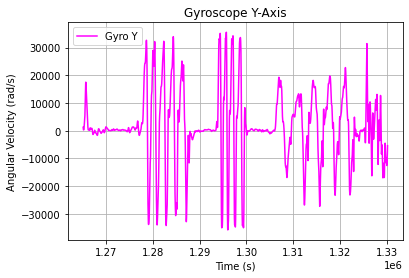

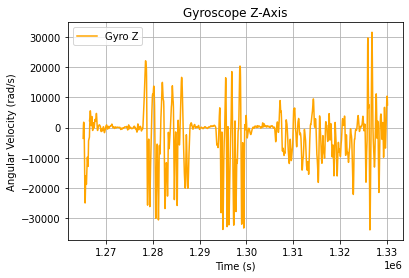

In [15]:
# Adjust timestamps to match the length of smoothed data
adjusted_timestamps = timestamps[:len(smoothed_accel_x)]  # All smoothed arrays have the same length

# Now, use adjusted_timestamps in the plots
plt.figure()
plt.plot(adjusted_timestamps, smoothed_accel_x, label="Accel X", color='blue')
plt.title("Accelerometer X-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(adjusted_timestamps, smoothed_accel_y, label="Accel Y", color='green')
plt.title("Accelerometer Y-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(adjusted_timestamps, smoothed_accel_z, label="Accel Z", color='red')
plt.title("Accelerometer Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (m/s^2)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(adjusted_timestamps, smoothed_gyro_x, label="Gyro X", color='cyan')
plt.title("Gyroscope X-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(adjusted_timestamps, smoothed_gyro_y, label="Gyro Y", color='magenta')
plt.title("Gyroscope Y-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.grid(True)
plt.legend()
plt.show()

plt.figure()
plt.plot(adjusted_timestamps, smoothed_gyro_z, label="Gyro Z", color='orange')
plt.title("Gyroscope Z-Axis")
plt.xlabel("Time (s)")
plt.ylabel("Angular Velocity (rad/s)")
plt.grid(True)
plt.legend()
plt.show()


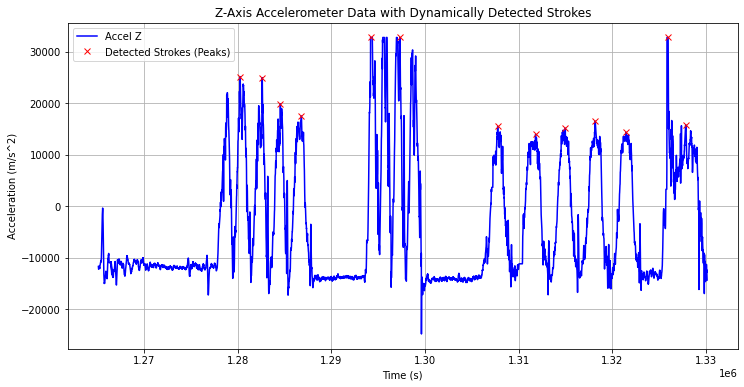

Mean: -3457.75, Std Dev: 12142.17, Max: 32767.00
Dynamic Height Threshold: 11458.64
Dynamic Distance Threshold: 150 samples
Total Detected Peaks: 13


In [17]:
from scipy.signal import find_peaks
import numpy as np

# Extract Z-axis data
timestamps = data['Time']
accel_z = data['AccelZ']

# Calculate dynamic thresholds
mean_value = np.mean(accel_z)
std_dev = np.std(accel_z)
max_value = np.max(accel_z)

# Dynamically set the 'height' threshold based on mean and standard deviation
height_threshold = 0.9 * mean_value +  1.2 * std_dev  

# Dynamically set the 'distance' between peaks (based on sampling rate or data characteristics)
sampling_rate = 30  # Assuming data is collected at 30
distance_threshold = int(sampling_rate * 5) # peaks can't be within this distance_threshold.

#TODO: This metric as well as height threshold will need to be adjusted as we get some real swimming data 

# Detect peaks
peaks, properties = find_peaks(
    accel_z,
    height=height_threshold,  # Minimum height
    distance=distance_threshold,  # Minimum distance between peaks
    prominence=0.5 * std_dev  # Optional: Require significant prominence
)

# Plot the Z-axis data with detected peaks
plt.figure(figsize=(12, 6))
plt.plot(timestamps, accel_z, label='Accel Z', color='blue')
plt.plot(timestamps[peaks], accel_z[peaks], 'rx', label='Detected Strokes (Peaks)')
plt.title('Z-Axis Accelerometer Data with Dynamically Detected Strokes')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.legend()
plt.grid(True)
plt.show()

# Print the dynamic parameters for debugging
print(f"Mean: {mean_value:.2f}, Std Dev: {std_dev:.2f}, Max: {max_value:.2f}")
print(f"Dynamic Height Threshold: {height_threshold:.2f}")
print(f"Dynamic Distance Threshold: {distance_threshold} samples")
print(f"Total Detected Peaks: {len(peaks)}")



In [19]:
# This block calculates the ground truth for average strokes per second and strokes per minute

import numpy as np
from scipy.signal import find_peaks

# Extract Z-axis data and timestamps
timestamps = data['Time']
accel_z = data['AccelZ']

# Dynamically calculate thresholds for peak detection
mean_value = np.mean(accel_z)
std_dev = np.std(accel_z)
max_value = np.max(accel_z)

# Find peaks dynamically
height_threshold = mean_value + 1.3 * std_dev  # Adjusted multiplier for leniency
distance_threshold = 20  # Adjust distance as needed
peaks, _ = find_peaks(accel_z, height=height_threshold, distance=distance_threshold)

# Total number of strokes (peaks)
total_strokes = len(peaks)

# Total time in seconds
total_time_seconds = timestamps.iloc[-1] - timestamps.iloc[0]  # Difference between first and last timestamp

# Total time in minutes
total_time_minutes = total_time_seconds / 60.0

# Calculate average stroke rates
average_stroke_rate_per_second = total_strokes / total_time_seconds
average_stroke_rate_per_minute = total_strokes / total_time_minutes

# Print results
print(f"Total Strokes (Peaks): {total_strokes}")
print(f"Total Time: {total_time_seconds:.2f} seconds ({total_time_minutes:.2f} minutes)")
print(f"Average Stroke Rate: {average_stroke_rate_per_second:.2f} strokes/second")
print(f"Average Stroke Rate: {average_stroke_rate_per_minute:.2f} strokes/minute")


Total Strokes (Peaks): 38
Total Time: 64970.00 seconds (1082.83 minutes)
Average Stroke Rate: 0.00 strokes/second
Average Stroke Rate: 0.04 strokes/minute


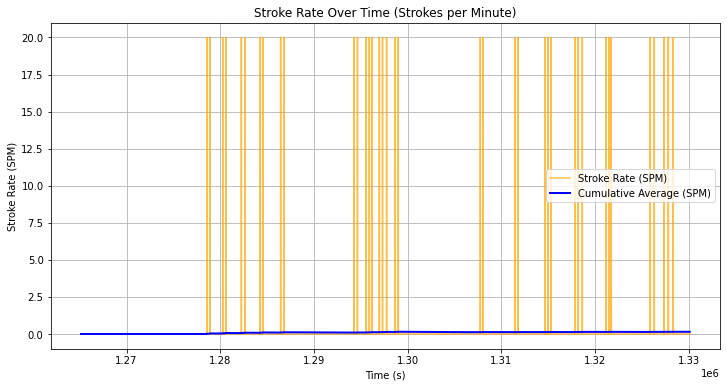

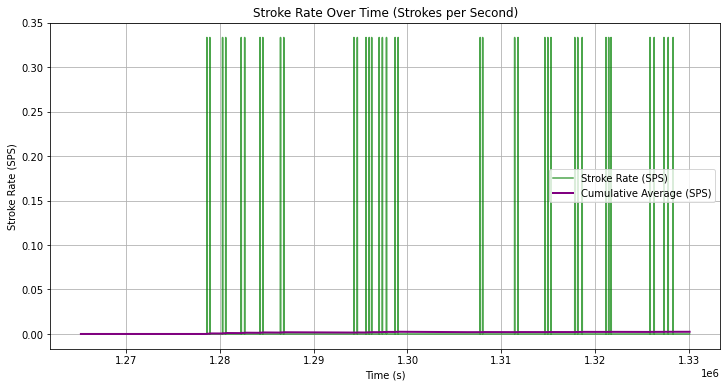

Final Cumulative Average Stroke Rate: 0.15 strokes/minute
Final Cumulative Average Stroke Rate: 0.00 strokes/second
Ground Truth Stroke Rate: 0.04 strokes/minute
Ground Truth Stroke Rate: 0.00 strokes/second


In [20]:
# This Block calculates stroke rate.
# It uses a sliding time window of the last 3 seconds to count 
# how many strokes occurred in that time.

import pandas as pd
import matplotlib.pyplot as plt

# Calculate stroke rate (SPM: Strokes Per Minute) and SPS (Strokes Per Second)
stroke_rate_spm = []
stroke_rate_sps = []  # Strokes per second
cumulative_spm = []  # Cumulative average SPM
cumulative_sps = []  # Cumulative average SPS
window = 3  # Window size in seconds for stroke rate calculation

for i, t in enumerate(timestamps):
    # Count peaks in the last `window` seconds
    start_time = t - window
    valid_peaks = [p for p in peaks if timestamps[p] >= start_time and timestamps[p] <= t]
    
    # Stroke rate in strokes per minute
    rate_spm = len(valid_peaks) * (60 / window)  # Convert to strokes per minute
    stroke_rate_spm.append(rate_spm)
    
    # Stroke rate in strokes per second
    rate_sps = len(valid_peaks) / window  # Convert to strokes per second
    stroke_rate_sps.append(rate_sps)
    
    # Cumulative averages
    cumulative_spm.append(sum(stroke_rate_spm) / len(stroke_rate_spm))  # Average of SPM so far
    cumulative_sps.append(sum(stroke_rate_sps) / len(stroke_rate_sps))  # Average of SPS so far

# Plot the stroke rate (Strokes per Minute) with cumulative average
plt.figure(figsize=(12, 6))
plt.plot(timestamps, stroke_rate_spm, label='Stroke Rate (SPM)', color='orange', alpha=0.7)
plt.plot(timestamps, cumulative_spm, label='Cumulative Average (SPM)', color='blue', linewidth=2)
plt.title('Stroke Rate Over Time (Strokes per Minute)')
plt.xlabel('Time (s)')
plt.ylabel('Stroke Rate (SPM)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the stroke rate (Strokes per Second) with cumulative average
plt.figure(figsize=(12, 6))
plt.plot(timestamps, stroke_rate_sps, label='Stroke Rate (SPS)', color='green', alpha=0.7)
plt.plot(timestamps, cumulative_sps, label='Cumulative Average (SPS)', color='purple', linewidth=2)
plt.title('Stroke Rate Over Time (Strokes per Second)')
plt.xlabel('Time (s)')
plt.ylabel('Stroke Rate (SPS)')
plt.legend()
plt.grid(True)
plt.show()

# Final cumulative averages
final_spm_average = cumulative_spm[-1]  # Final cumulative average SPM
final_sps_average = cumulative_sps[-1]  # Final cumulative average SPS

# Ground truth values
total_strokes = len(peaks)  # Total number of peaks (strokes)
total_time_seconds = timestamps.iloc[-1] - timestamps.iloc[0]  # Total duration in seconds
total_time_minutes = total_time_seconds / 60.0  # Total duration in minutes
ground_truth_spm = total_strokes / total_time_minutes  # Ground truth strokes per minute
ground_truth_sps = total_strokes / total_time_seconds  # Ground truth strokes per second

# Print final cumulative averages and ground truth
print(f"Final Cumulative Average Stroke Rate: {final_spm_average:.2f} strokes/minute")
print(f"Final Cumulative Average Stroke Rate: {final_sps_average:.2f} strokes/second")
print(f"Ground Truth Stroke Rate: {ground_truth_spm:.2f} strokes/minute")
print(f"Ground Truth Stroke Rate: {ground_truth_sps:.2f} strokes/second")
